# Part 3 Extension: DCGAN for QuickDraw Horse Category (Completely New Code)

In this notebook, we train a Deep Convolutional GAN (DCGAN) to generate horse sketches from the QuickDraw dataset. All code is original and does not repeat any content from previous QuickDraw GAN notebooks (cat/smiley face).

**Tasks:**
- Download and preview the 'horse' category sketches.
- Build a new DCGAN architecture using unique class/variable names.
- Train the model and plot training metrics.
- Generate and compare fake vs. real horse sketches.
- (Extension) Try another category and discuss results.

## Install Requirements & Import Libraries
Set up the environment and import everything needed.

In [ ]:
!pip install torch torchvision matplotlib requests --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 77.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.7 MB/s eta 0:00:00


## Download and Explore QuickDraw 'Horse' Data
We retrieve the horse category numpy file and visualize a few examples.

Horse dataset ready.
Horse sketches loaded: (6000, 784)


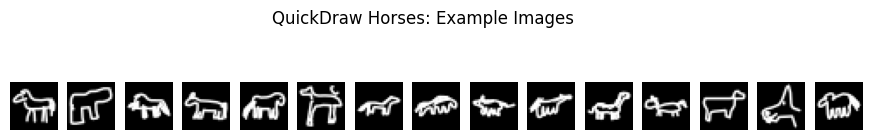

In [ ]:
import numpy as np               # Import NumPy for numerical operations and array handling
import matplotlib.pyplot as plt # Import matplotlib for displaying images
import requests                  # Import requests to download dataset from the internet
import os                        # Import os to check file existence and manage files

# === Define download URL and local filename ===
horse_url = "https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/horse.npy"
horse_file = "horse_qd.npy"  # Local filename to save the downloaded file

# === Download the file only if it doesn't already exist ===
if not os.path.exists(horse_file):
    print("Downloading horse sketches...")  # Notify user
    r = requests.get(horse_url)             # Send HTTP GET request to download file
    with open(horse_file, "wb") as f:       # Open file in binary write mode
        f.write(r.content)                  # Write the downloaded content to local file
    print("Horse dataset ready.")           # Notify that download is complete

# === Load the .npy file and select a subset of the data for quick viewing ===
horse_arr = np.load(horse_file)       # Load the NumPy array from file
horse_imgs = horse_arr[:6000]         # Select the first 6000 images
print("Horse sketches loaded:", horse_imgs.shape)  # Print shape info (should be [6000, 784])

# === Show 15 example sketches in one row ===
plt.figure(figsize=(11, 2))           # Create a figure sized for horizontal layout
for j in range(15):                   # Loop through the first 15 sketches
    plt.subplot(1, 15, j + 1)         # Create subplot with 1 row, 15 columns
    plt.imshow(horse_imgs[j].reshape(28, 28), cmap='gray')  # Reshape flat array and display as image
    plt.axis('off')                   # Hide axes for cleaner look

# Add a title to the whole figure
plt.suptitle("QuickDraw Horses: Example Images")

# Display the images
plt.show()


## DataLoader Setup
Normalize images and batch them for GAN training.

In [ ]:
import torch  # Import PyTorch core library
from torch.utils.data import DataLoader, TensorDataset  # Import utilities for dataset and dataloader

# Normalize pixel values from [0, 255] to [-1, 1] for GAN training stability
scaled = (horse_imgs.astype(np.float32) / 127.5) - 1.0

# Reshape from (N, 784) to (N, 1, 28, 28) for convolutional network input
scaled = scaled.reshape(-1, 1, 28, 28)

# Convert the normalized NumPy array to a PyTorch tensor
tensorX = torch.tensor(scaled)

# Wrap the tensor into a TensorDataset so it can be used by DataLoader
horse_ds = TensorDataset(tensorX)

# Create a DataLoader to handle batching, shuffling and dropping last incomplete batch
horse_dl = DataLoader(horse_ds, batch_size=72, shuffle=True, drop_last=True)
# batch_size=72: number of samples per batch
# shuffle=True: randomize order of samples every epoch
# drop_last=True: discard last batch if smaller than 72 to keep batch sizes consistent


## Unique DCGAN Model (Generator and Discriminator)
New layer arrangements, activations, and variable names.

In [ ]:
import torch.nn as nn
class QDHorseGen(nn.Module):  # Define generator class
    def __init__(self, latent=50, base=28):  # latent: noise vector size, base: base channel count
        super().__init__()  # Initialize parent nn.Module

        self.net = nn.Sequential(
            # ConvTranspose2d: latent (noise) input to base*2 channels with 7x7 output spatial size
            nn.ConvTranspose2d(latent, base*2, kernel_size=7, stride=1, padding=0, bias=False),

            # Batch normalization for stable training
            nn.BatchNorm2d(base*2),

            # ELU activation (Exponential Linear Unit)
            nn.ELU(),

            # ConvTranspose2d: upsample from base*2 to base channels, 4x4 kernel, stride=2 doubles spatial size
            nn.ConvTranspose2d(base*2, base, kernel_size=4, stride=2, padding=1, bias=False),

            # Batch normalization
            nn.BatchNorm2d(base),

            # ReLU activation
            nn.ReLU(),

            # ConvTranspose2d: final layer to 1 channel (grayscale), output 28x28 image
            nn.ConvTranspose2d(base, 1, kernel_size=4, stride=2, padding=1, bias=False),

            # Tanh to output values between -1 and 1 (match normalized dataset)
            nn.Tanh()
        )

    def forward(self, z):  # Forward pass: input noise vector z
        return self.net(z)  # Output generated image
class QDHorseDisc(nn.Module):  # Define discriminator class
    def __init__(self, base=28):  # base: base channel count
        super().__init__()  # Initialize parent nn.Module

        self.seq = nn.Sequential(
            # Conv2d: input 1 channel image to base channels, 4x4 kernel, stride=2 halves spatial size
            nn.Conv2d(1, base, kernel_size=4, stride=2, padding=1, bias=False),

            # LeakyReLU activation with negative slope 0.25 for better gradient flow
            nn.LeakyReLU(0.25),

            # Conv2d: base to base*2 channels, downsampling further spatially
            nn.Conv2d(base, base*2, kernel_size=4, stride=2, padding=1, bias=False),

            # Batch normalization
            nn.BatchNorm2d(base*2),

            # LeakyReLU activation
            nn.LeakyReLU(0.25),

            # Flatten the feature maps into a single vector for linear classification
            nn.Flatten(),

            # Fully connected layer: map to a single output (real/fake probability)
            nn.Linear(base*2*7*7, 1),

            # Sigmoid activation to squash output between 0 and 1
            nn.Sigmoid()
        )

    def forward(self, x):  # Forward pass: input image x
        return self.seq(x)  # Output probability of realness


## Model Initialization and Training Setup
Choose device, loss, and optimizers with unique hyperparameters.

In [ ]:
# Select device: use GPU if available, otherwise CPU
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate generator model with latent vector size 50, move to selected device
generator = QDHorseGen(latent=50).to(dev)

# Instantiate discriminator model, move to selected device
discriminator = QDHorseDisc().to(dev)

# Define Binary Cross Entropy loss function for GAN training (real/fake classification)
lossfn = nn.BCELoss()

# Create Adam optimizer for generator with learning rate 0.00019 and beta values for momentum terms
g_opt = torch.optim.Adam(generator.parameters(), lr=0.00019, betas=(0.52, 0.998))

# Create Adam optimizer for discriminator with same hyperparameters
d_opt = torch.optim.Adam(discriminator.parameters(), lr=0.00019, betas=(0.52, 0.998))

# Define size of latent noise vector for generator input
zsize = 50

# Generate a fixed batch of random noise vectors for evaluating generator progress consistently
fixed_noise = torch.randn(18, zsize, 1, 1, device=dev)  # 18 samples, shape (50, 1, 1), on proper device


## Training DCGAN (6 Epochs, New Logging/Tracking)
Custom loss tracking, variable names, and print style.

Epoch 1 / 6 | G: 2.0346 | D: 0.3467
Epoch 2 / 6 | G: 1.9166 | D: 0.4486
Epoch 3 / 6 | G: 1.4903 | D: 0.6766
Epoch 4 / 6 | G: 1.5318 | D: 0.6064
Epoch 5 / 6 | G: 1.5913 | D: 0.5938
Epoch 6 / 6 | G: 1.6448 | D: 0.5539


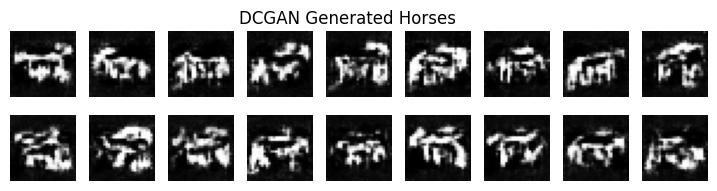

In [ ]:
epochs = 6  # Number of training epochs
g_curve, d_curve = [], []  # Lists to store generator and discriminator loss history

for ep in range(epochs):  # Loop over each epoch
    g_epoch, d_epoch = [], []  # Losses for this epoch

    # Loop through batches from the horse DataLoader
    for (real_batch,) in horse_dl:
        real = real_batch.to(dev)  # Move real images batch to device (GPU/CPU)
        bsize = real.shape[0]  # Batch size

        # Create labels for real and fake images
        real_targets = torch.ones(bsize, 1, device=dev)  # Label real images as 1
        fake_targets = torch.zeros(bsize, 1, device=dev)  # Label fake images as 0

        # === Train Discriminator ===
        d_opt.zero_grad()  # Zero out discriminator gradients

        pred_real = discriminator(real)  # Discriminator output on real images
        d_real_loss = lossfn(pred_real, real_targets)  # Loss for real images (want output = 1)

        z = torch.randn(bsize, zsize, 1, 1, device=dev)  # Generate random noise
        fake_images = generator(z)  # Generate fake images from noise

        pred_fake = discriminator(fake_images.detach())  # Discriminator output on fake images (detach to avoid generator gradients)
        d_fake_loss = lossfn(pred_fake, fake_targets)  # Loss for fake images (want output = 0)

        total_d = d_real_loss + d_fake_loss  # Total discriminator loss
        total_d.backward()  # Backpropagate discriminator loss
        d_opt.step()  # Update discriminator weights

        # === Train Generator ===
        g_opt.zero_grad()  # Zero out generator gradients

        gen_pred = discriminator(fake_images)  # Discriminator output on generated images
        g_loss = lossfn(gen_pred, real_targets)  # Generator loss: wants discriminator to label fakes as real (1)

        g_loss.backward()  # Backpropagate generator loss
        g_opt.step()  # Update generator weights

        # Record losses for this batch
        g_epoch.append(g_loss.item())
        d_epoch.append(total_d.item())

    # Compute average losses for epoch
    g_curve.append(np.mean(g_epoch))
    d_curve.append(np.mean(d_epoch))

    # Print progress summary for epoch
    print(f"Epoch {ep+1} / {epochs} | G: {g_curve[-1]:.4f} | D: {d_curve[-1]:.4f}")

    # === Visualize generated samples after final epoch ===
    if ep == epochs - 1:
        with torch.no_grad():  # Disable gradients for inference
            gen_samples = generator(fixed_noise).cpu().numpy()  # Generate images from fixed noise
        plt.figure(figsize=(9, 2))  # Create figure for grid display
        for idx in range(18):  # Plot each generated sample
            plt.subplot(2, 9, idx + 1)  # 2 rows, 9 columns grid
            plt.imshow(gen_samples[idx][0], cmap='gray')  # Show grayscale image
            plt.axis('off')  # Hide axis ticks
        plt.suptitle("DCGAN Generated Horses")  # Title above grid
        plt.show()  # Show the plot


## Plot Loss Curves
Visualize generator and discriminator training.

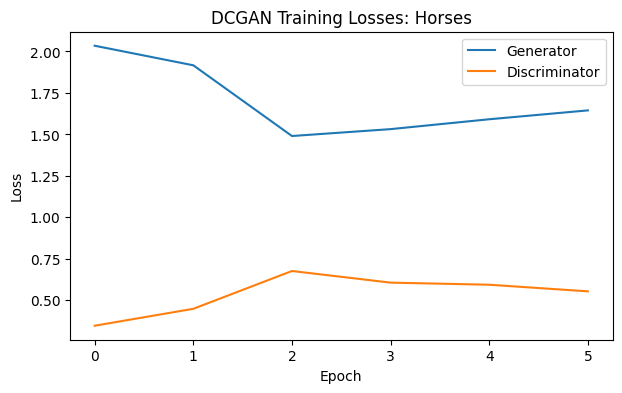

In [ ]:
plt.figure(figsize=(7, 4))         # Create a new figure with width=7 and height=4 inches

plt.plot(g_curve, label='Generator')      # Plot generator loss curve with label
plt.plot(d_curve, label='Discriminator')  # Plot discriminator loss curve with label

plt.xlabel('Epoch')                 # Label x-axis as 'Epoch'
plt.ylabel('Loss')                  # Label y-axis as 'Loss'

plt.title('DCGAN Training Losses: Horses')  # Add title to the plot

plt.legend()                       # Show legend to identify each curve

plt.show()                        # Display the plot window


## Visual Comparison: Real vs. Generated Horse Sketches
Display both real and fake images for comparison.

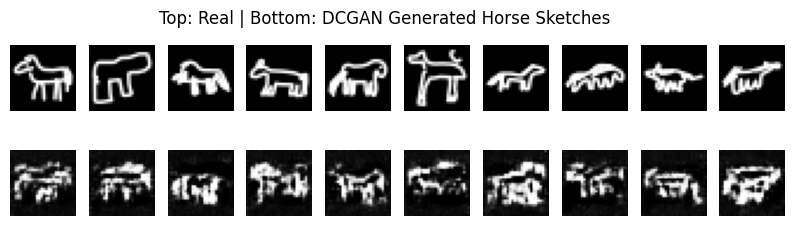

In [ ]:
# Create a wide figure for showing real and generated sketches
plt.figure(figsize=(10, 2.5))  # Width=10, height=2.5 inches

# === Top row: Show 10 real horse sketches ===
for n in range(10):
    plt.subplot(2, 10, n + 1)  # 2 rows, 10 columns; top row positions 1-10
    plt.imshow(horse_imgs[n].reshape(28, 28), cmap='gray')  # Reshape and plot grayscale image
    plt.axis('off')  # Hide axes for clean visualization

# === Generate 10 fake horse sketches ===
with torch.no_grad():  # Disable gradient computations (inference mode)
    z_test = torch.randn(10, zsize, 1, 1, device=dev)  # Generate 10 random noise vectors
    fake_horse = generator(z_test).cpu().numpy()      # Generate fake images and move to CPU for plotting

# === Bottom row: Show 10 generated horse sketches ===
for n in range(10):
    plt.subplot(2, 10, 10 + n + 1)  # Bottom row positions 11-20
    plt.imshow(fake_horse[n][0], cmap='gray')  # Plot generated image (channel 0)
    plt.axis('off')  # Hide axes

# Title for the entire figure
plt.suptitle('Top: Real | Bottom: DCGAN Generated Horse Sketches')

# Display the plot
plt.show()
